In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"


def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def load_images(image_dir, mask_dir, img_size=(256, 256)):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    images = []
    masks = []

    for image_path, mask_path in zip(image_paths, mask_paths):
        image = load_img(image_path, target_size=img_size, color_mode="grayscale")
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

        image = img_to_array(image) / 255.0
        mask = img_to_array(mask) / 255.0
        masks.append(mask)
        images.append(image)

    return np.array(images), np.array(masks)

def load_images_rgb(image_dir, mask_dir, img_size=(256, 256)):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    images = []
    masks = []

    for image_path, mask_path in zip(image_paths, mask_paths):
        image = load_img(image_path, target_size=img_size, color_mode="rgb")
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

        image = img_to_array(image) / 255.0
        mask = img_to_array(mask) / 255.0
        masks.append(mask)
        images.append(image)

    return np.array(images), np.array(masks)

def plot_training_history(history):
    plt.figure(figsize=(18, 8))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    if 'accuracy' in history.history:
        plt.subplot(2, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

    if 'dice_coefficient' in history.history:
        plt.subplot(2, 2, 3)
        plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
        plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
        plt.title('DICE Coefficient')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

    if 'iou_coefficient' in history.history:
        plt.subplot(2, 2, 4)
        plt.plot(history.history['iou_coefficient'], label='Train IoU')
        plt.plot(history.history['val_iou_coefficient'], label='Validation IoU')
        plt.title('IoU (Intersection over Union)')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
image_dir = '/home/orin/Datasets/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
mask_dir = '/home/orin/Datasets/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

X, Y = load_images(image_dir, mask_dir)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## U-net model

In [ ]:
def unet_model(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(0.5)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(0.5)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(0.5)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(0.5)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(0.5)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(0.5)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.5)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.5)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.5)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.5)(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(0.5)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(0.5)(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Dropout(0.5)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Dropout(0.5)(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Dropout(0.5)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Dropout(0.5)(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Dropout(0.5)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Dropout(0.5)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coefficient, iou_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 rmalization)                   )                                                                 
                                                                                                  
 dropout_8 (Dropout)            (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['dropout_8[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 dropout_16 (Dropout)           (None, 256, 256, 64  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='unet_vanilla_model.h5',
    monitor='val_dice_coefficient',
    mode='max',
    save_weights_only=False,
    save_best_only=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=4,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
300/300 [==============================] - 104s 313ms/step - loss: 0.4481 - accuracy: 0.9255 - dice_coefficient: 0.7820 - iou_coefficient: 0.6548 - val_loss: 2.4510 - val_accuracy: 0.7985 - val_dice_coefficient: 0.0015 - val_iou_coefficient: 7.6088e-04
Epoch 2/50
300/300 [==============================] - 92s 308ms/step - loss: 0.2753 - accuracy: 0.9546 - dice_coefficient: 0.8612 - iou_coefficient: 0.7569 - val_loss: 2.1892 - val_accuracy: 0.7988 - val_dice_coefficient: 0.0088 - val_iou_coefficient: 0.0044
Epoch 3/50
300/300 [==============================] - 93s 309ms/step - loss: 0.2458 - accuracy: 0.9590 - dice_coefficient: 0.8753 - iou_coefficient: 0.7787 - val_loss: 0.6980 - val_accuracy: 0.9104 - val_dice_coefficient: 0.7093 - val_iou_coefficient: 0.5537
Epoch 4/50
300/300 [==============================] - 94s 312ms/step - loss: 0.2212 - accuracy: 0.9627 - dice_coefficient: 0.8874 - iou_coefficient: 0.7979 - val_loss: 0.6994 - val_accuracy: 0.9122 - val_dice_coefficie

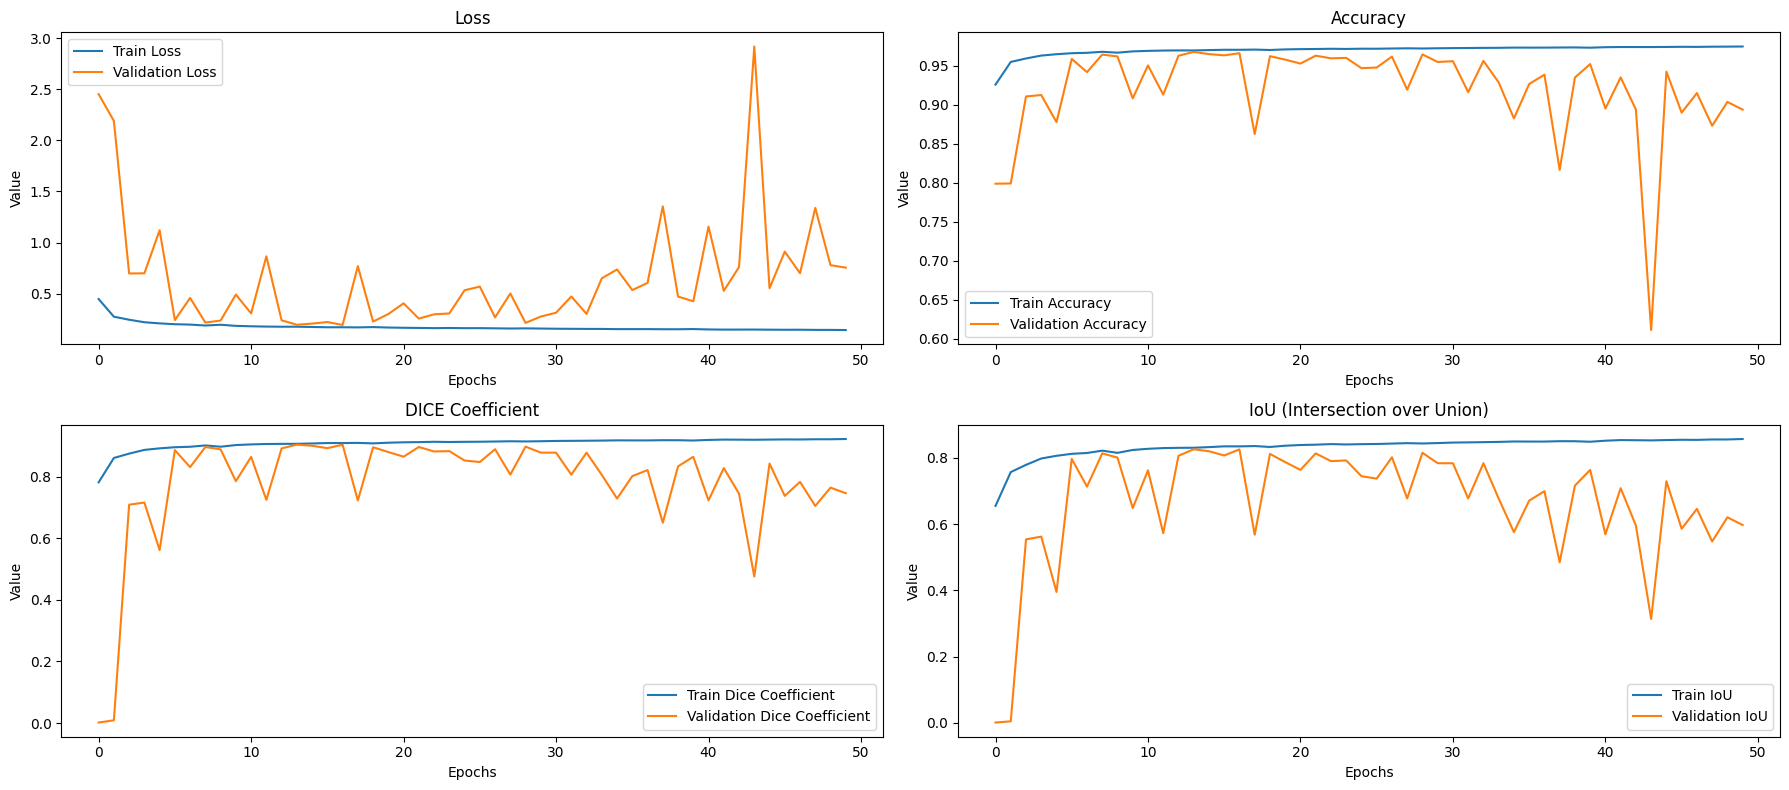

In [ ]:
plot_training_history(history)

In [ ]:
model.save("unet_model2.h5")

In [ ]:
model = tf.keras.models.load_model("unet_vanilla_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

In [ ]:
loss, accuracy, dice_coefficient, iou_coefficient = model.evaluate(X_test, Y_test)

10/10 [==============================] - 6s 536ms/step - loss: 0.1964 - accuracy: 0.9674 - dice_coefficient: 0.9049 - iou_coefficient: 0.8263


## U-Net++ model

In [ ]:
def conv_block(inputs, filters, dropout_rate=0.5):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x


def unet_plus_plus_model(input_size=(256, 256, 1), base_filters=64):
    inputs = layers.Input(input_size)

    # Downsampling path
    c11 = conv_block(inputs, base_filters)
    p1 = layers.MaxPooling2D((2, 2))(c11)

    c21 = conv_block(p1, base_filters * 2)
    p2 = layers.MaxPooling2D((2, 2))(c21)

    c31 = conv_block(p2, base_filters * 4)
    p3 = layers.MaxPooling2D((2, 2))(c31)

    c41 = conv_block(p3, base_filters * 8)
    p4 = layers.MaxPooling2D((2, 2))(c41)

    c51 = conv_block(p4, base_filters * 16)

    # Upsampling path
    u41 = layers.UpSampling2D((2, 2))(c51)
    m41 = layers.Concatenate()([u41, c41])
    c42 = conv_block(m41, base_filters * 8)

    u31 = layers.UpSampling2D((2, 2))(c42)
    m31 = layers.Concatenate()([u31, c31])
    c32 = conv_block(m31, base_filters * 4)

    u21 = layers.UpSampling2D((2, 2))(c32)
    m21 = layers.Concatenate()([u21, c21])
    c22 = conv_block(m21, base_filters * 2)

    u11 = layers.UpSampling2D((2, 2))(c22)
    m11 = layers.Concatenate()([u11, c11])
    c12 = conv_block(m11, base_filters)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c12)

    return models.Model(inputs, outputs)

In [ ]:
model = unet_plus_plus_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coefficient, iou_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

                                                                                                  
 up_sampling2d_4 (UpSampling2D)  (None, 32, 32, 1024  0          ['batch_normalization_27[0][0]'] 
                                )                                                                 
                                                                                                  
 concatenate_4 (Concatenate)    (None, 32, 32, 1536  0           ['up_sampling2d_4[0][0]',        
                                )                                 'batch_normalization_25[0][0]'] 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 32, 32, 512)  7078400     ['concatenate_4[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_29[0][0]']              
 ormalizat

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='unet_plus_plus_model.h5',
    monitor='val_dice_coefficient',
    mode='max',
    save_weights_only=False,
    save_best_only=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=4,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
300/300 [==============================] - 107s 323ms/step - loss: 0.3921 - accuracy: 0.9359 - dice_coefficient: 0.8025 - iou_coefficient: 0.6797 - val_loss: 2.4284 - val_accuracy: 0.7986 - val_dice_coefficient: 0.0017 - val_iou_coefficient: 8.6913e-04
Epoch 2/50
300/300 [==============================] - 96s 320ms/step - loss: 0.2402 - accuracy: 0.9590 - dice_coefficient: 0.8743 - iou_coefficient: 0.7771 - val_loss: 0.3973 - val_accuracy: 0.9403 - val_dice_coefficient: 0.8189 - val_iou_coefficient: 0.6941
Epoch 3/50
300/300 [==============================] - 96s 319ms/step - loss: 0.2123 - accuracy: 0.9633 - dice_coefficient: 0.8886 - iou_coefficient: 0.8000 - val_loss: 0.2625 - val_accuracy: 0.9572 - val_dice_coefficient: 0.8722 - val_iou_coefficient: 0.7739
Epoch 4/50
300/300 [==============================] - 95s 318ms/step - loss: 0.1939 - accuracy: 0.9662 - dice_coefficient: 0.8981 - iou_coefficient: 0.8153 - val_loss: 0.2124 - val_accuracy: 0.9648 - val_dice_coefficie

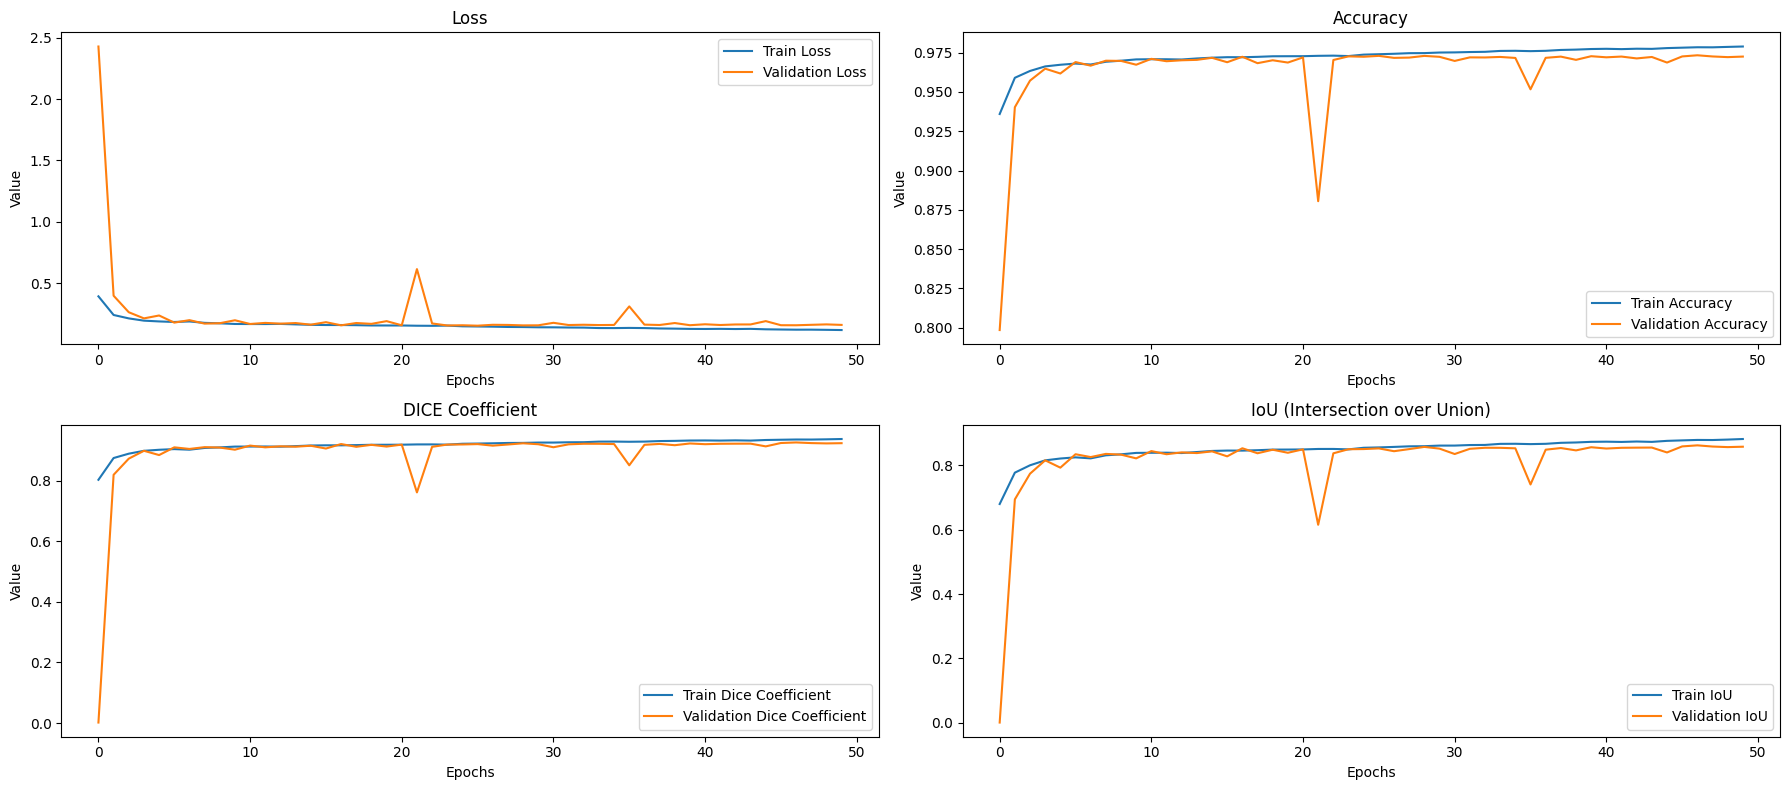

In [ ]:
plot_training_history(history)

In [ ]:
model = tf.keras.models.load_model("unet_plus_plus_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

In [ ]:
loss, accuracy, dice_coefficient, iou_coefficient = model.evaluate(X_test, Y_test)

10/10 [==============================] - 67s 7s/step - loss: 0.1561 - accuracy: 0.9733 - dice_coefficient: 0.9263 - iou_coefficient: 0.8627


## U-Net 3+ model

In [ ]:
def conv_block(inputs, filters, dropout_rate=0.5):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x


def unet_3_plus_model(input_size=(256, 256, 1), base_filters=64):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling Path)
    c1 = conv_block(inputs, base_filters)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, base_filters * 2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, base_filters * 4)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, base_filters * 8)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, base_filters * 16)

    # Decoder (Upsampling Path with Aggregation)
    d4 = layers.UpSampling2D((2, 2))(c5)
    d4 = layers.Concatenate()([d4, c4, layers.UpSampling2D((2, 2))(c5)])
    d4 = conv_block(d4, base_filters * 8)

    d3 = layers.UpSampling2D((2, 2))(d4)
    d3 = layers.Concatenate()([d3, c3, layers.UpSampling2D((4, 4))(c5)])
    d3 = conv_block(d3, base_filters * 4)

    d2 = layers.UpSampling2D((2, 2))(d3)
    d2 = layers.Concatenate()([d2, c2, layers.UpSampling2D((8, 8))(c5)])
    d2 = conv_block(d2, base_filters * 2)

    d1 = layers.UpSampling2D((2, 2))(d2)
    d1 = layers.Concatenate()([d1, c1, layers.UpSampling2D((16, 16))(c5)])
    d1 = conv_block(d1, base_filters)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d1)

    return models.Model(inputs, outputs)

In [ ]:
model = unet_3_plus_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coefficient, iou_coefficient])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 256)    │              0 │ batch_normalization_4… │
├──────────────────────

 Total params: 40,248,705 (153.54 MB)

 Trainable params: 40,236,929 (153.49 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='unet_3_plus_model.keras',
    monitor='val_dice_coefficient',
    mode='max',
    save_weights_only=False,
    save_best_only=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=4,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8654 - dice_coefficient: 0.6523 - iou_coefficient: 0.5051 - loss: 0.7379 - val_accuracy: 0.7985 - val_dice_coefficient: 0.0085 - val_iou_coefficient: 0.0043 - val_loss: 2.0911
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9557 - dice_coefficient: 0.8592 - iou_coefficient: 0.7534 - loss: 0.2690 - val_accuracy: 0.7986 - val_dice_coefficient: 0.0033 - val_iou_coefficient: 0.0016 - val_loss: 2.2976
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9615 - dice_coefficient: 0.8783 - iou_coefficient: 0.7832 - loss: 0.2276 - val_accuracy: 0.8419 - val_dice_coefficient: 0.3639 - val_iou_coefficient: 0.2247 - val_loss: 1.5326
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9640 - dice_coefficient: 0.8913 - iou_coefficient: 0.8041 - loss: 0.2062 - val_accuracy: 0.9574 - val_dice_coefficient: 0.8691 - val_iou_coefficient: 0.7687 - val_loss: 0.2513
Epoch 5/50
150/150 ━━━━━━━━━

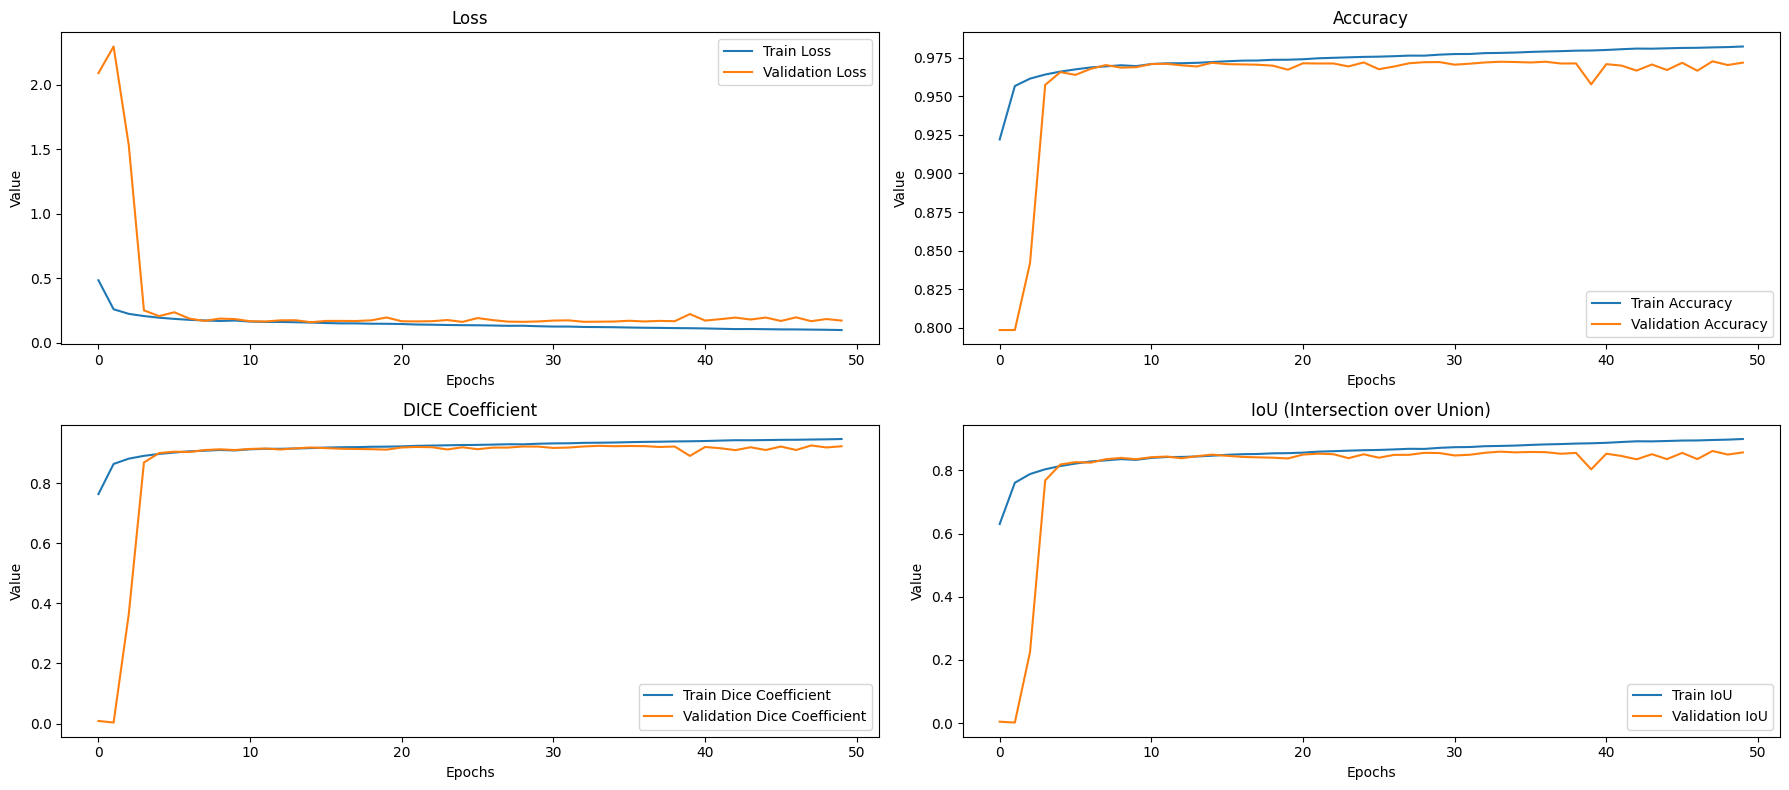

In [ ]:
plot_training_history(history)

In [ ]:
model = tf.keras.models.load_model("unet_3_plus_model.keras",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

In [ ]:
loss, accuracy, dice_coefficient, iou_coefficient = model.evaluate(X_test, Y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.9729 - dice_coefficient: 0.9271 - iou_coefficient: 0.8641 - loss: 0.1637


## U-Net Attention model

In [ ]:
def conv_block(inputs, filters, dropout_rate=0.5):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def attention_gate(x, g, filters):
    theta_x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    phi_g = layers.Conv2D(filters, (1, 1), padding='same')(g)

    add_xg = layers.Add()([theta_x, phi_g])
    act_xg = tf.keras.activations.relu(add_xg)

    psi = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(act_xg)
    return layers.Multiply()([x, psi])

def unet_attention_model(input_size=(256, 256, 1), base_filters=64):
    inputs = layers.Input(input_size)

    # Downsampling path
    c11 = conv_block(inputs, base_filters)
    p1 = layers.MaxPooling2D((2, 2))(c11)

    c21 = conv_block(p1, base_filters * 2)
    p2 = layers.MaxPooling2D((2, 2))(c21)

    c31 = conv_block(p2, base_filters * 4)
    p3 = layers.MaxPooling2D((2, 2))(c31)

    c41 = conv_block(p3, base_filters * 8)
    p4 = layers.MaxPooling2D((2, 2))(c41)

    c51 = conv_block(p4, base_filters * 16)

    # Upsampling path with Attention Gates
    u41 = layers.UpSampling2D((2, 2))(c51)
    ag41 = attention_gate(c41, u41, base_filters * 8)
    m41 = layers.Concatenate()([u41, ag41])
    c42 = conv_block(m41, base_filters * 8)

    u31 = layers.UpSampling2D((2, 2))(c42)
    ag31 = attention_gate(c31, u31, base_filters * 4)
    m31 = layers.Concatenate()([u31, ag31])
    c32 = conv_block(m31, base_filters * 4)

    u21 = layers.UpSampling2D((2, 2))(c32)
    ag21 = attention_gate(c21, u21, base_filters * 2)
    m21 = layers.Concatenate()([u21, ag21])
    c22 = conv_block(m21, base_filters * 2)

    u11 = layers.UpSampling2D((2, 2))(c22)
    ag11 = attention_gate(c11, u11, base_filters)
    m11 = layers.Concatenate()([u11, ag11])
    c12 = conv_block(m11, base_filters)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c12)

    return models.Model(inputs, outputs)

In [ ]:
model = unet_attention_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coefficient, iou_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 32, 32, 1024  0           ['batch_normalization_9[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 512)  262656      ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  524800      ['up_sampling2d[0][0]']          
                                                                                                  
 add (Add)                      (None, 32, 32, 512)  0           ['conv2d_10[0][0]',              
                                                                  'conv2d_11[0][0]']              
          

                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 38  0           ['up_sampling2d_2[0][0]',        
                                4)                                'multiply_2[0][0]']             
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 12  442496      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 128, 128, 12  512        ['conv2d_23[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 dropout_7

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='unet_attention_model.h5',
    monitor='val_dice_coefficient',
    mode='max',
    save_weights_only=False,
    save_best_only=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=4,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
300/300 [==============================] - 123s 373ms/step - loss: 0.3916 - accuracy: 0.9344 - dice_coefficient: 0.8014 - iou_coefficient: 0.6790 - val_loss: 2.1655 - val_accuracy: 0.7986 - val_dice_coefficient: 0.0071 - val_iou_coefficient: 0.0036
Epoch 2/50
300/300 [==============================] - 112s 372ms/step - loss: 0.2365 - accuracy: 0.9596 - dice_coefficient: 0.8759 - iou_coefficient: 0.7798 - val_loss: 0.5730 - val_accuracy: 0.9195 - val_dice_coefficient: 0.7483 - val_iou_coefficient: 0.6005
Epoch 3/50
300/300 [==============================] - 116s 386ms/step - loss: 0.2115 - accuracy: 0.9633 - dice_coefficient: 0.8893 - iou_coefficient: 0.8010 - val_loss: 0.2009 - val_accuracy: 0.9653 - val_dice_coefficient: 0.8949 - val_iou_coefficient: 0.8100
Epoch 4/50
300/300 [==============================] - 114s 379ms/step - loss: 0.1992 - accuracy: 0.9654 - dice_coefficient: 0.8955 - iou_coefficient: 0.8111 - val_loss: 0.2100 - val_accuracy: 0.9651 - val_dice_coefficien

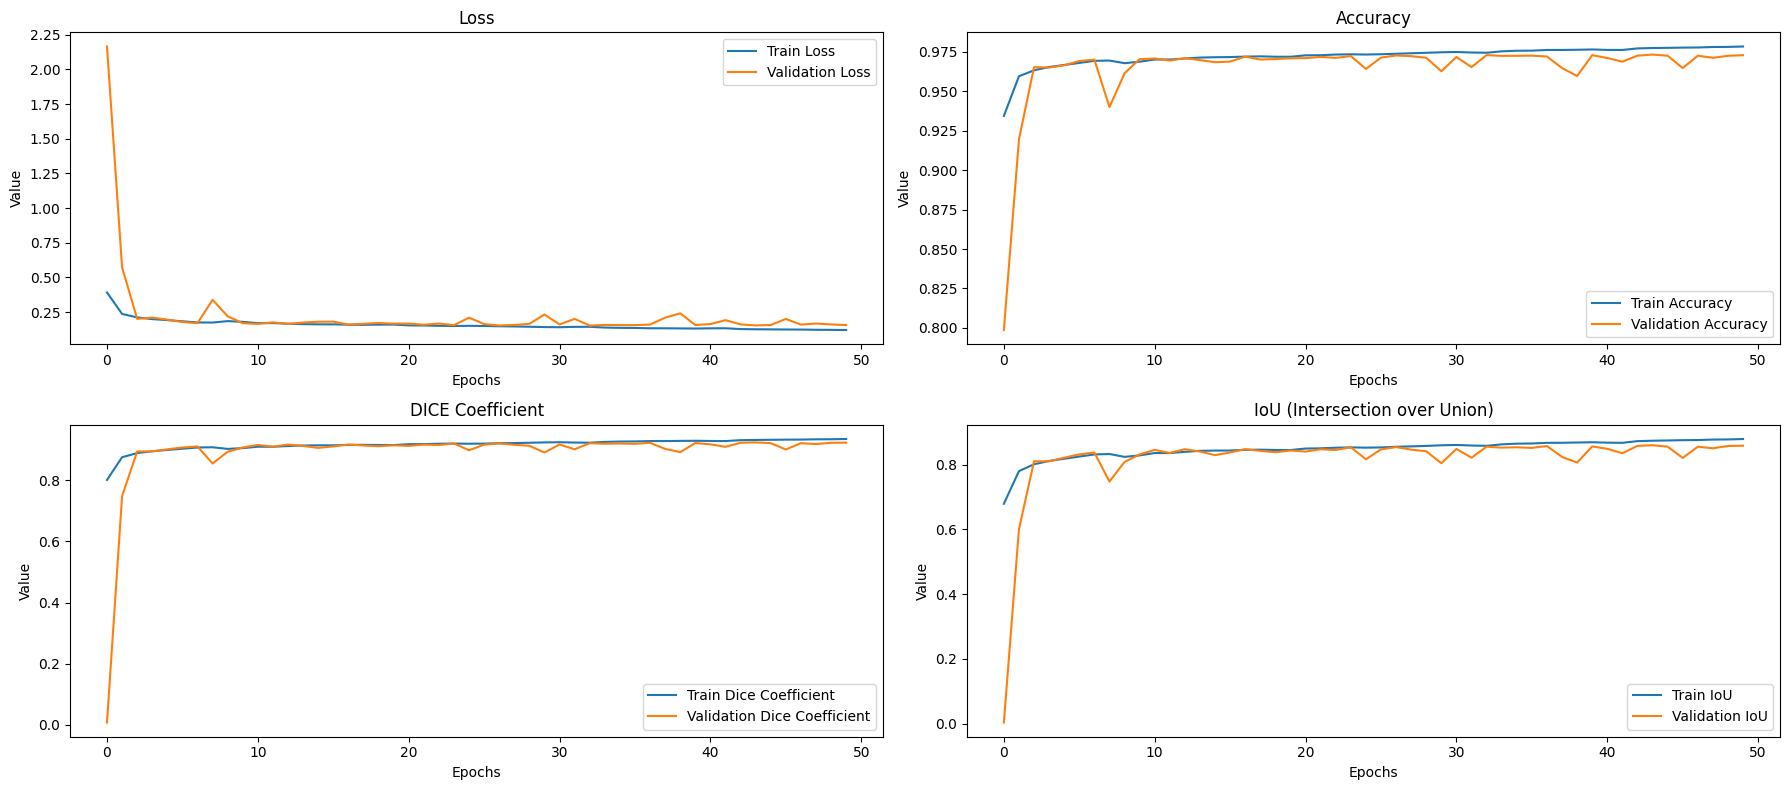

In [ ]:
plot_training_history(history)

In [ ]:
model = tf.keras.models.load_model("unet_attention_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

In [ ]:
with tf.device('CPU'):
    loss, accuracy, dice_coefficient, iou_coefficient = model.evaluate(X_test, Y_test)

10/10 [==============================] - 74s 7s/step - loss: 0.1535 - accuracy: 0.9733 - dice_coefficient: 0.9249 - iou_coefficient: 0.8604


## U-Net Residual model

In [ ]:
def residual_block(inputs, filters, dropout_rate=0.5):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Residual connection
    shortcut = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    x = layers.Add()([x, shortcut])
    return x

def unet_residual_model(input_size=(256, 256, 1), base_filters=64):
    inputs = layers.Input(input_size)

    # Downsampling path
    c11 = residual_block(inputs, base_filters)
    p1 = layers.MaxPooling2D((2, 2))(c11)

    c21 = residual_block(p1, base_filters * 2)
    p2 = layers.MaxPooling2D((2, 2))(c21)

    c31 = residual_block(p2, base_filters * 4)
    p3 = layers.MaxPooling2D((2, 2))(c31)

    c41 = residual_block(p3, base_filters * 8)
    p4 = layers.MaxPooling2D((2, 2))(c41)

    c51 = residual_block(p4, base_filters * 16)

    # Upsampling path
    u41 = layers.UpSampling2D((2, 2))(c51)
    m41 = layers.Concatenate()([u41, c41])
    c42 = residual_block(m41, base_filters * 8)

    u31 = layers.UpSampling2D((2, 2))(c42)
    m31 = layers.Concatenate()([u31, c31])
    c32 = residual_block(m31, base_filters * 4)

    u21 = layers.UpSampling2D((2, 2))(c32)
    m21 = layers.Concatenate()([u21, c21])
    c22 = residual_block(m21, base_filters * 2)

    u11 = layers.UpSampling2D((2, 2))(c22)
    m11 = layers.Concatenate()([u11, c11])
    c12 = residual_block(m11, base_filters)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c12)

    return models.Model(inputs, outputs)

In [ ]:
model = unet_residual_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coefficient, iou_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  131584      ['max_pooling2d_2[0][0]']        
                                                                                                  
 add_3 (Add)                    (None, 32, 32, 512)  0           ['batch_normalization_7[0][0]',  
                                                                  'conv2d_11[0][0]']              
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 512)  0          ['add_3[0][0]']                  
                                                                                                  
 conv2d_12 (Conv2D)             (None, 16, 16, 1024  4719616     ['max_pooling2d_3[0][0]']        
                                )                                                                 
          

 batch_normalization_14 (BatchN  (None, 128, 128, 12  512        ['conv2d_21[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 12  0           ['batch_normalization_14[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 12  147584      ['dropout_7[0][0]']              
                                8)                                                                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 12  512        ['conv2d_22[0][0]']              
 ormalizat

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='unet_residual_model.h5',
    monitor='val_dice_coefficient',
    mode='max',
    save_weights_only=False,
    save_best_only=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=4,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
300/300 [==============================] - 124s 375ms/step - loss: 0.3259 - accuracy: 0.9426 - dice_coefficient: 0.8318 - iou_coefficient: 0.7184 - val_loss: 2.6063 - val_accuracy: 0.7986 - val_dice_coefficient: 0.0012 - val_iou_coefficient: 6.0981e-04
Epoch 2/50
300/300 [==============================] - 112s 373ms/step - loss: 0.2174 - accuracy: 0.9617 - dice_coefficient: 0.8851 - iou_coefficient: 0.7942 - val_loss: 0.3768 - val_accuracy: 0.9404 - val_dice_coefficient: 0.8272 - val_iou_coefficient: 0.7058
Epoch 3/50
300/300 [==============================] - 112s 373ms/step - loss: 0.1946 - accuracy: 0.9657 - dice_coefficient: 0.8972 - iou_coefficient: 0.8139 - val_loss: 0.1979 - val_accuracy: 0.9657 - val_dice_coefficient: 0.8974 - val_iou_coefficient: 0.8142
Epoch 4/50
300/300 [==============================] - 111s 370ms/step - loss: 0.1836 - accuracy: 0.9677 - dice_coefficient: 0.9032 - iou_coefficient: 0.8237 - val_loss: 0.2931 - val_accuracy: 0.9444 - val_dice_coeffi

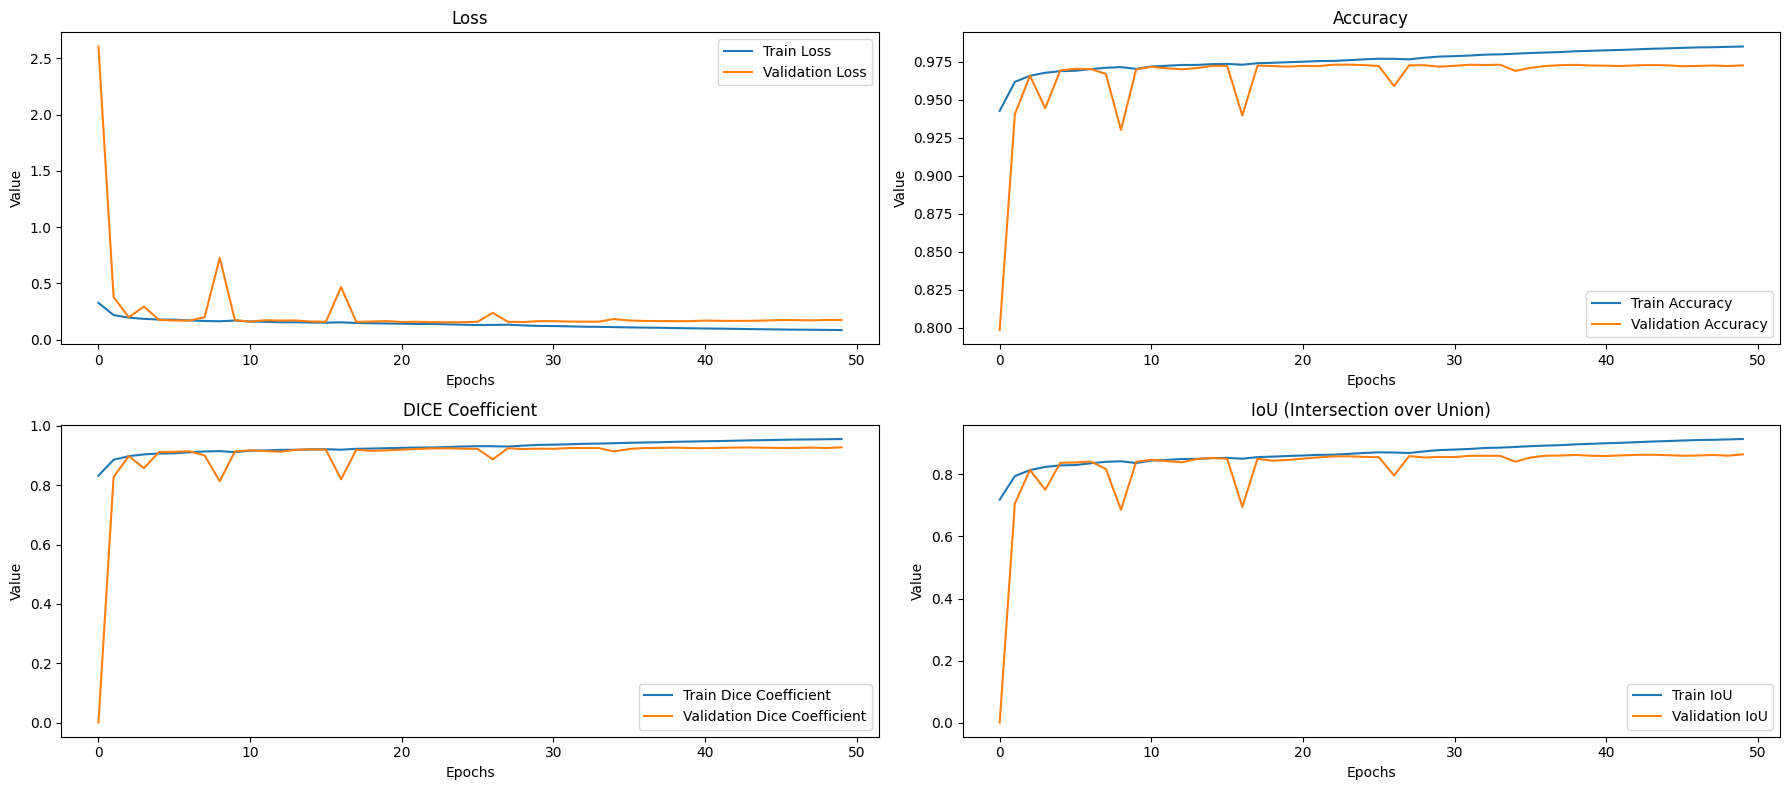

In [ ]:
plot_training_history(history)

In [ ]:
model = tf.keras.models.load_model("unet_residual_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

In [ ]:
with tf.device('CPU'):
    loss, accuracy, dice_coefficient, iou_coefficient = model.evaluate(X_test, Y_test)

10/10 [==============================] - 81s 8s/step - loss: 0.1732 - accuracy: 0.9726 - dice_coefficient: 0.9276 - iou_coefficient: 0.8650


## DeepLabV3+ (ResNet-101) model

In [ ]:
def AtrousSpatialPyramidPooling(input_tensor, filters):
    shape = input_tensor.shape[1:3]

    # 1x1 convolution
    conv1 = layers.Conv2D(filters, 1, padding='same', use_bias=False)(input_tensor)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    # 3x3 convolution with different atrous rates
    conv2 = layers.Conv2D(filters, 3, padding='same', dilation_rate=6, use_bias=False)(input_tensor)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters, 3, padding='same', dilation_rate=12, use_bias=False)(input_tensor)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)

    conv4 = layers.Conv2D(filters, 3, padding='same', dilation_rate=18, use_bias=False)(input_tensor)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)

    # Image-level features
    global_pool = layers.GlobalAveragePooling2D()(input_tensor)
    global_pool = layers.Reshape((1, 1, global_pool.shape[-1]))(global_pool)
    global_pool = layers.Conv2D(filters, 1, padding='same', use_bias=False)(global_pool)
    global_pool = layers.BatchNormalization()(global_pool)
    global_pool = layers.ReLU()(global_pool)
    global_pool = layers.UpSampling2D(size=shape, interpolation='bilinear')(global_pool)

    # Concatenate all features
    concatenated = layers.Concatenate()([conv1, conv2, conv3, conv4, global_pool])
    output = layers.Conv2D(filters, 1, padding='same', use_bias=False)(concatenated)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)

    return output

def deeplabv3_plus_resnet101_model(input_shape=(256, 256, 3), num_classes=1, base_model_filters=256):
    inputs = layers.Input(shape=input_shape)

    base_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_tensor=inputs)
    low_level_features = base_model.get_layer('conv2_block3_out').output
    encoder_output = base_model.get_layer('conv4_block23_out').output

    # ASPP
    aspp_output = AtrousSpatialPyramidPooling(encoder_output, base_model_filters)
    aspp_output = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(aspp_output)

    # Low-level features processing
    low_level_features = layers.Conv2D(48, 1, padding='same', use_bias=False)(low_level_features)
    low_level_features = layers.BatchNormalization()(low_level_features)
    low_level_features = layers.ReLU()(low_level_features)

    # Concatenate ASPP output and low-level features
    concatenated = layers.Concatenate()([aspp_output, low_level_features])

    # Decoder
    decoder_output = layers.Conv2D(256, 3, padding='same', use_bias=False)(concatenated)
    decoder_output = layers.BatchNormalization()(decoder_output)
    decoder_output = layers.ReLU()(decoder_output)
    decoder_output = layers.Conv2D(256, 3, padding='same', use_bias=False)(decoder_output)
    decoder_output = layers.BatchNormalization()(decoder_output)
    decoder_output = layers.ReLU()(decoder_output)

    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(decoder_output)
    outputs = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(outputs)

    return models.Model(inputs, outputs)

In [ ]:
image_dir = '/home/orin/Datasets/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
mask_dir = '/home/orin/Datasets/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

X, Y = load_images_rgb(image_dir, mask_dir)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
model = deeplabv3_plus_resnet101_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coefficient, iou_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block7_out[0][0]']       
                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block8_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block8_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block8_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block10_out[0][0]']      
                                                                                                  
 conv4_block11_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block13_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block13_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block13_out[0][0]']      
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block16_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block17_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block16_out[0][0]']      
                                                                                                  
 conv4_block17_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block17_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block17_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block17_1_bn[0][0]']     
 on)      

                                )                                 'conv4_block19_3_bn[0][0]']     
                                                                                                  
 conv4_block19_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block19_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block19_out[0][0]']      
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block22_add (Add)        (None, 16, 16, 1024  0           ['conv4_block21_out[0][0]',      
                                )                                 'conv4_block22_3_bn[0][0]']     
                                                                                                  
 conv4_block22_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block22_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block22_out[0][0]']      
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
          

 conv2d_5 (Conv2D)              (None, 16, 16, 256)  327680      ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 16, 16, 256)  1024       ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 64, 48)   12288       ['conv2_block3_out[0][0]']       
                                                                                                  
 re_lu_5 (ReLU)                 (None, 16, 16, 256)  0           ['batch_normalization_5[0][0]']  
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 64, 48)  192         ['conv2d_6[0][0]']               
 rmalizati

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='deeplabv3_plus_resnet101_model.h5',
    monitor='val_dice_coefficient',
    mode='max',
    save_weights_only=False,
    save_best_only=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=4,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
300/300 [==============================] - 76s 201ms/step - loss: 0.3255 - accuracy: 0.9436 - dice_coefficient: 0.8199 - iou_coefficient: 0.6974 - val_loss: 2.2909 - val_accuracy: 0.7985 - val_dice_coefficient: 0.0048 - val_iou_coefficient: 0.0024
Epoch 2/50
300/300 [==============================] - 59s 195ms/step - loss: 0.2701 - accuracy: 0.9527 - dice_coefficient: 0.8441 - iou_coefficient: 0.7305 - val_loss: 2.8531 - val_accuracy: 0.7986 - val_dice_coefficient: 9.4182e-04 - val_iou_coefficient: 4.8200e-04
Epoch 3/50
300/300 [==============================] - 60s 199ms/step - loss: 0.2656 - accuracy: 0.9536 - dice_coefficient: 0.8464 - iou_coefficient: 0.7339 - val_loss: 0.8077 - val_accuracy: 0.8071 - val_dice_coefficient: 0.6453 - val_iou_coefficient: 0.4778
Epoch 4/50
300/300 [==============================] - 60s 199ms/step - loss: 0.2600 - accuracy: 0.9544 - dice_coefficient: 0.8492 - iou_coefficient: 0.7381 - val_loss: 0.3038 - val_accuracy: 0.9485 - val_dice_coeffi

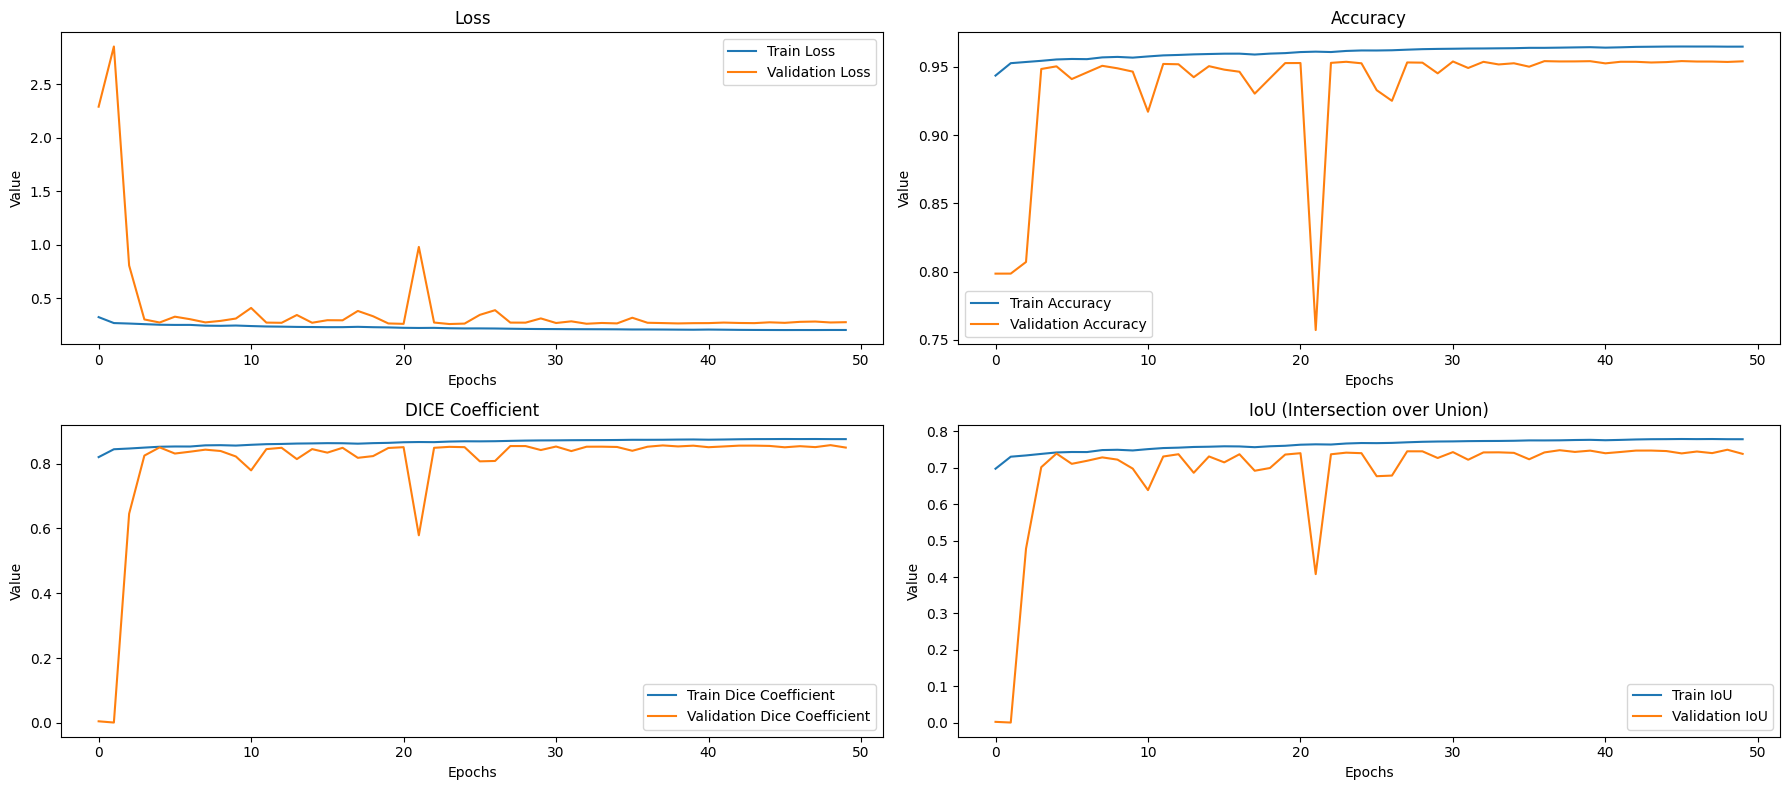

In [ ]:
plot_training_history(history)

In [ ]:
model = tf.keras.models.load_model("deeplabv3_plus_resnet101_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

In [ ]:
with tf.device('CPU'):
    loss, accuracy, dice_coefficient, iou_coefficient = model.evaluate(X_test, Y_test)

10/10 [==============================] - 30s 3s/step - loss: 0.2752 - accuracy: 0.9536 - dice_coefficient: 0.8571 - iou_coefficient: 0.7499


## Model predictions

In [ ]:
with tf.device('CPU'):
    predictions = model.predict(X_test)

10/10 [==============================] - 48s 5s/step


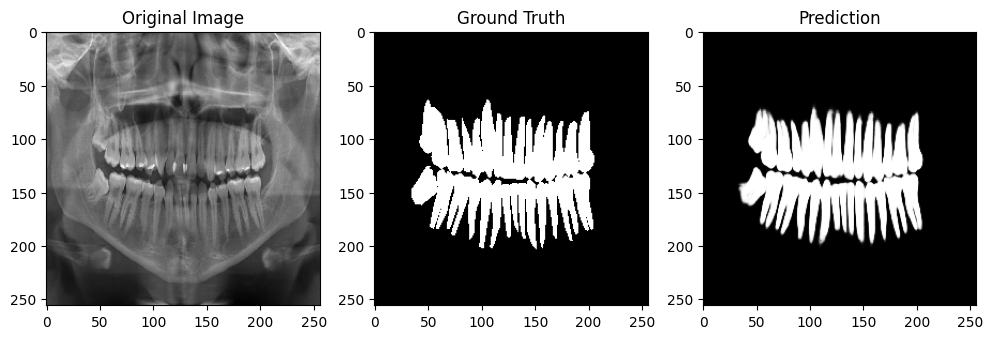

In [ ]:
def plot_sample(image, mask, prediction):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.show()

plot_sample(X_test[0], Y_test[0], predictions[0])

In [ ]:
unet_model = tf.keras.models.load_model("unet_vanilla_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

attention_unet_model = tf.keras.models.load_model("unet_attention_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

residual_unet_model = tf.keras.models.load_model("unet_residual_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

unet_plus_plus_model = tf.keras.models.load_model("unet_se_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

unet_3plus_model = tf.keras.models.load_model("unet_plus_plus_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })

deeplabv3_plus_resnet101_model = tf.keras.models.load_model("deeplabv3_plus_resnet101_model.h5",
            custom_objects={"bce_dice_loss": bce_dice_loss,
                            "dice_coefficient": dice_coefficient,
                            "iou_coefficient": iou_coefficient })


models = [
    ("U-Net", unet_model),
    ("Attention U-Net", attention_unet_model),
    ("Residual U-Net", residual_unet_model),
    ("U-Net++", unet_plus_plus_model),
    ("U-Net 3+", unet_3plus_model),
    ("DeepLabV3+ (ResNet-101)", deeplabv3_plus_resnet101_model),
]

In [ ]:
def load_images_rgb(image_dir, mask_dir, img_size=(256, 256)):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    images = []
    masks = []
    images2 = []

    for image_path, mask_path in zip(image_paths, mask_paths):
        image = load_img(image_path, target_size=img_size, color_mode="grayscale")
        image2 = load_img(image_path, target_size=img_size, color_mode="rgb")
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

        image = img_to_array(image) / 255.0
        image2 = img_to_array(image2) / 255.0

        mask = img_to_array(mask) / 255.0
        masks.append(mask)
        images.append(image)
        images2.append(image2)

    return np.array(images), np.array(images2), np.array(masks)

image_dir = '/home/orin/Datasets/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
mask_dir = '/home/orin/Datasets/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

X_test, X_test2, Y_test = load_images_rgb(image_dir, mask_dir)

In [ ]:
X_test = X_test[:10]
X_test2 = X_test2[:10]

predicted_masks = []
model_names = []

image = X_test[7]
mask = Y_test[7]

with tf.device('CPU'):
    for i, (model_name, model) in enumerate(models):
        if model_name != "DeepLabV3+ (ResNet-101)":
            predicted_masks.append(model.predict(X_test)[7])
        else:
            predicted_masks.append(model.predict(X_test2)[7])
        model_names.append(model_name)

1/1 [==============================] - 1s 918ms/step


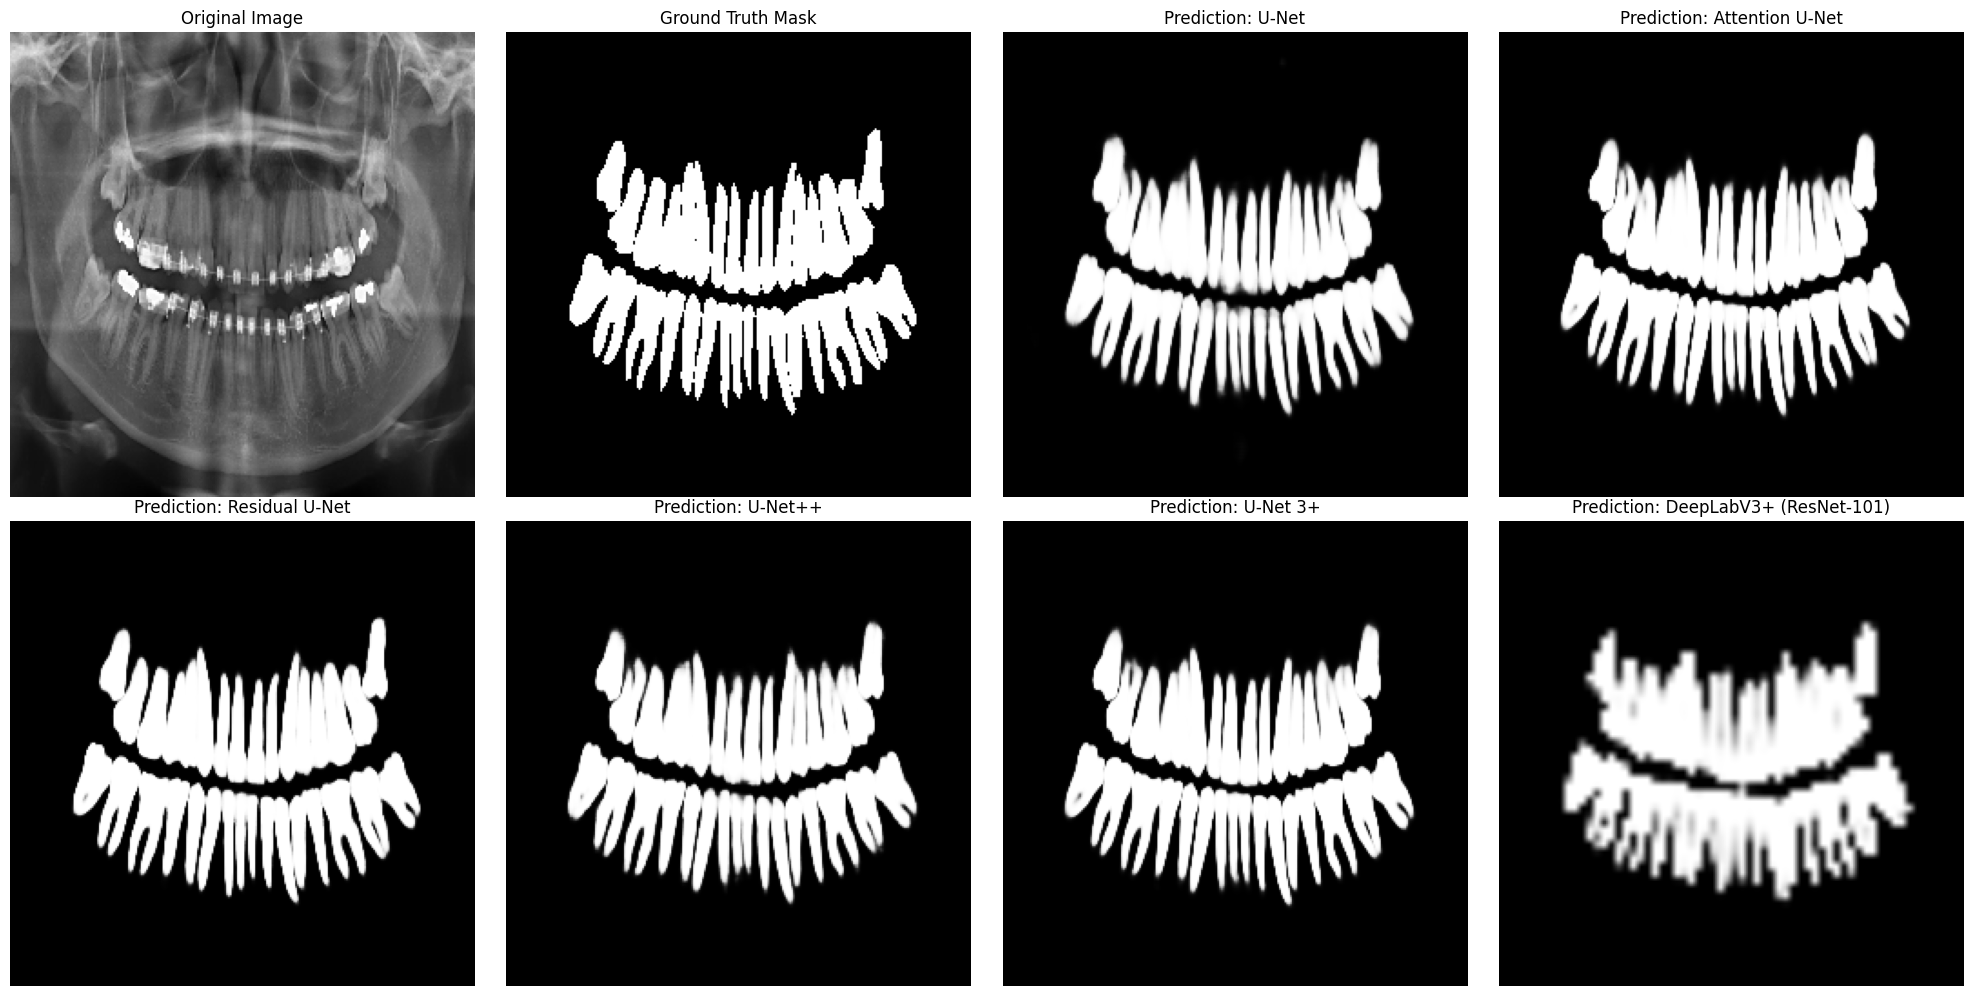

In [ ]:
def display_predictions(image, mask, predicted_masks, model_names):
    #num_models = len(models)
    #fig, axes = plt.subplots(1, num_models + 2, figsize=(5 * (num_models + 2), 5))

    num_elements = min(len(models) + 2, 8)

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    for i in range(len(predicted_masks)):
        axes[i + 2].imshow(predicted_masks[i], cmap='gray')
        axes[i + 2].set_title(f"Prediction: {model_names[i]}")
        axes[i + 2].axis('off')



    plt.tight_layout()
    plt.show()

with tf.device('CPU'):
    display_predictions(image, mask, predicted_masks, model_names)